# Naive Bayes

Naive Bayes refers to the use of Bayes' theorem with naive independence assumptions between features.

Naive Bayes classifers are popular for categorizing text. The goal of this module is to learn the basics of Naive Bayes and the ways Naive Bayes is improved for the purposes of sentiment analysis. The module is split into a few sections:

+ Prepare the data for analysis
+ Introduction to Naive Bayes
+ Improvement 1: Dealing with negation
+ Improvement 2: Bigrams
+ Improvement 3: Binary count Naive Bayes
+ Improvement 4: Dealing with Informal text

This module coincides with our lecture on improving naive bayes for sentiment analysis. 

Before we delve into section 1 on data preparation, we will begin by doing an overview of the data we're using. For the reader's understanding of the methodology, we:

1. First, pulled the Twitter data related to microfinance using tweepy, a Twitter API library. 
2. Next, we classified the comments into sentiment polarities in order to obtain training data for our model. 
    + Normally this process would require manually classifying ~20% of our data. 
    + In our exercise, we leveraged a simple wordnet algorithm called TextBlob to tag the entire data set. 
3. We then manually reviewed and corrected classiications. 
    + (Note, if you are interested in seeing the code used to implement this, see the file titled "twitter_web_scraping.") 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import string
import nltk
# if you have never done so, you need to download stopwords from nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
import re
import itertools
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

from nltk.sentiment.util import mark_negation
from nltk import word_tokenize

/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
#load data
data = pd.read_csv("microfinance_tweets.csv", encoding="ISO-8859-1")

In [ ]:
#load data by getting it from github, if using colab

!git clone https://github.com/DeltaAnalytics/machine_learning_for_good_data
data = pd.read_csv("machine_learning_for_good_data/microfinance_tweets.csv", encoding="ISO-8859-1")

In [3]:
#check data to see if everything worked
data.head(10)

,Comments,Date,Favorites,User,Polarity,Sentiment
0,RT @atmadiprayET: Here's why Janalakshmi Finan...,3/22/2018 5:40,0,Saloni Shukla,-0.100000,negative
1,RT @ecosmob: Ecosmob's #Mobility solutions for...,3/22/2018 5:36,0,Sindhav Bhageerath,-0.062500,neutral
2,Project have big future! Microfinance is belie...,3/22/2018 5:27,0,Konstantin #savedroidICO,0.166667,positive
3,#Online #Banking- Yako Microfinance Bank prov...,3/22/2018 5:21,0,YakoMicrofinance,0.500000,positive
4,MICROFINANCE EVENT: 3rd BoP Global Network Sum...,3/22/2018 5:19,0,MicroCapital,0.045455,positive
5,RT @FINCA: .@rupertscofield spoke with @techwe...,3/22/2018 5:08,0,Right Angles,0.000000,neutral
6,Capacity building and knowledge management are...,3/22/2018 5:03,0,@barbara_zawedde,0.144444,positive
7,"RT @oluabudu: Get a cash loan of N200,000 to N...",3/22/2018 5:00,0,Tola Abudu,0.136364,positive
8,RT @PoojaMedia: From being an influencer for a...,3/22/2018 4:59,0,idee,0.000000,neutral
9,RT @WhatWorksVAWG: Read latest blog from Erin ...,3/22/2018 4:58,0,Sofia Sprechmann,0.500000,positive


The Twitter data contains six columns:
+ Comments: the Twitter post that was made mentionining microfinance
+ Date: date the post was created on Twitter
+ Favorites: number of favorites the post has
+ User: name of the user who posted the comment
+ Polarity: the polarity, representing the degree of positivity versus negatvity that textblob deemed the post
+ Sentiment: a conversion of polarity into positive, negative, and neutral classifications

Note that this exercise really does simulate what would happen in a real world situation. Our data is limited, and the process to get the quality training and test data we need (with labeled polarity) is a diffult one. To understand the nature of our data, we will conduct a few exercises below.

neutral     1943
positive    1039
negative     259
Name: Sentiment, dtype: int64

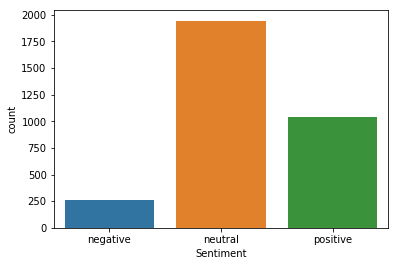

In [4]:
## What do we have for sentiment breakdown?
sns.countplot(x = 'Sentiment', data = data)
data['Sentiment'].value_counts()

It looks like most people have positive or neutral comments about microfinance. In fact, the volume of negative comments is the most interesting and should be investigated further.

In [5]:
## What are these negative comments?

#format columns so comments don't get cut off
pd.set_option('display.max_columns', None) 

#pull negative comments
data.loc[data['Sentiment'] == 'negative']['Comments'].unique()[0:10]

array(["RT @atmadiprayET: Here's why Janalakshmi Financial takes so long to small finance bank transition https://t.co/traKQNXuxe via @economictime\x85",
       "Here's why Janalakshmi Financial takes so long to small finance bank transition https://t.co/traKQNXuxe via\x85 https://t.co/6fk3hc1S9I",
       'RT @The_LHoFT: Why Luxembourg? ???\nA few of the reasons why #Luxembourg is home to a growing number of financial services innovators, inclu\x85',
       '@DataMufti Isnt it surprising that Telenor sold half of its Tameer microfinance stake to Alipay!!! To me it looks like a wrong move.',
       '+???? ????? ???? ??????? ???? \n?????? :NMB MICROFINANCE BITTIYA SANSTHA LIMITED \n?? \n?.Junior Field Officer \n?.Assi\x85 https://t.co/4onBO7RMTc',
       'HR Administrative Assistant at Crossover Microfinance Bank Limited Crossover Microfinance Bank Limited, is ... https://t.co/C9b5PAKKm9',
       'If the bank of Ghana is being this harsh on commercial banks, what will become of savings a

It seems like some of the negative comments are not valid and should actually be classified as neutral. However, some of the negative comments are valid, e.g. illegal activity. 

Usually we would clean these classifications to correct it, but we will move forward to preparing our data for the model.

# Prepare data for the model

The most common way to apply machine learning algorithms, such as Naive Bayes, to text analysis is to convert our text into numerical feature vectors that the algorithms can understand.

The representation we will create is the **Bag of Words**. To get from our data, which is currently structured as a Series of strings, to a Bag of Words, we will **vectorize** our tweets.

This **vectorization** of our text documents will require a few key steps, which we describe in more detail in [Module 8](https://docs.google.com/presentation/d/1vaxDuUROgaqix9Mfkyb4_h0cGkGwN7AUeLU1ozhtJW8/edit#slide=id.g227403103b_0_1171):

Step 0. Split data into training and test sets (this is not part of vectorization) <br>
Step 1. Clean and **tokenize** text <br>
Step 2. Count the number of words in each document

#### Step 0: Create training and test data
This step should come naturally. 
We have classified sentiments for all our data, and we choose an 80-20 training and test split, with observations assigned at random. 

In [6]:
# A) Create a set of test (20% of data) and training (80% of data) data
# We set a seed so this can be reproducible
np.random.seed(12345)
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [7]:
# Be sure to check the length of the training and test sets to confirm data was split in the correct porportions
print(len(train), len(test))
print("Split of {:.2%} train, {:.2%} test".format(len(train)/len(data), len(test)/len(data)))

2594 647
Split of 80.04% train, 19.96% test


#### Step 1: Clean and Tokenize Text

As mentioned, the most common way to extract numerical vectors from text is to have a set of text **tokens** for which we can have counts.

**Tokenization** means to convert a document/sentence/tweet into individual *tokens*, which are usually words, or word-like units. 

When creating these word-like tokens, we want to standardize them in a way that groups words with similar intent. This makes these token features more useful than unprocessed words. Check out the [NLP Module](https://docs.google.com/presentation/d/1vaxDuUROgaqix9Mfkyb4_h0cGkGwN7AUeLU1ozhtJW8/edit#slide=id.g227403103b_0_1050) for more details!

We create a function to
+ **lemmatize** these words
+ remove *stop words*, punctuation, URLs, numbers, and special characters

Luckily, NLTK has different libraries that make this task very easy.

In [8]:
# B) Lemmatize words, and remove stop words and punctuation
lemmatizer = WordNetLemmatizer()

def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove URLs
    2. Remove punctuation
    3. Remove numbers
    4. Remove stopwords
    5. Return the cleaned text as a list of lemmatized words
    '''
    
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text, flags=re.MULTILINE)
    
    text = ''.join([t for t in text if t not in string.punctuation])
    
    text = ''.join([t for t in text if not t.isdigit()])
    
    return [lemmatizer.lemmatize(word) for word in text.split() if word.lower() not in stopwords.words('english')]

In [9]:
# Let's test the function to make sure it's doing what we would expect
sample_text = "I LOVE love BBQ chicken pizza. I eat it every day, but sometimes I wonder if I'm being unhealthy https://ilove.pizza"
text_process(sample_text)

['LOVE',
 'love',
 'BBQ',
 'chicken',
 'pizza',
 'eat',
 'every',
 'day',
 'sometimes',
 'wonder',
 'Im',
 'unhealthy']

#### Step 2) Count the number of words in each 'document'

This is the step that brings our text to the representation as a *Bag of Words*.

A bag of words allows us to work with free text in a structured way. We use a simple count for our bag of words, but TF-IDF sklearn libraries are also available and can be used for other NLP problems.

We use the **CountVectorization** function from the sklearn library.

The TF-IDF Vectorizer is available by using:

`from sklearn.feature_extraction.text import TfidfVectorizer`

Note the difference in the use of the functions for fitting bag of words for test versus training data. 

In [10]:
# C) Represent the text in a bag-of-words by leveraging CountVectorization in the sklearn library.
vectorizer = CountVectorizer(analyzer=text_process)
train_features = vectorizer.fit_transform(train['Comments'])
test_features =  vectorizer.transform(test['Comments'])

In [11]:
vectorizer.get_feature_names()[0:20]

['AB',
 'ABMFBNIGERIA',
 'ACHT',
 'ACT',
 'ACTIVITIES',
 'ADB',
 'ADBHQ',
 'ADCs',
 'ADEL',
 'AEX',
 'AFG',
 'AFSG',
 'AGM',
 'AGOTonga',
 'AGm',
 'AI',
 'AID',
 'ALIBABA',
 'ALLEVIATION',
 'AMCResearch']

These are our *features*, i.e. all of the cleaned tokens from all of the tweets. A training or test tweet can now be represented as a count of how many times any of these features shows up. 

In [12]:
# Test the vectorizer by looking at the size of the vectors and snippets of the vectors
print('Length of Vectorizer Vocabulary: ', len(vectorizer.vocabulary_))
print('Shape of Sparse Matrix: ', test_features.shape)
print('Amount of Non-Zero occurrences: ', test_features.nnz)

# Percentage of non-zero values
density = 100.0 * (test_features.nnz / (test_features.shape[0] * test_features.shape[1]))
print('Density: {}'.format((density)))

Length of Vectorizer Vocabulary:  4890
Shape of Sparse Matrix:  (647, 4890)
Amount of Non-Zero occurrences:  6718
Density: 0.21233757818846147


We have 4890 *tokens* in our corpus. The test data features matrix is a representation of each of the 647 tweets as a vector of token counts. 

In [13]:
# To understand how the vectorizer stores words, we will input a sample test data review
sample_test = test['Comments'].iloc[0]
print("Sample comment: ", sample_test, "\n")
sample_vector = vectorizer.transform([sample_test])
print("Vectorization:")
print(sample_vector)

Sample comment:  RT @atmadiprayET: Here's why Janalakshmi Financial takes so long to small finance bank transition https://t.co/traKQNXuxe via @economictime 

Vectorization:
  (0, 755)	1
  (0, 925)	1
  (0, 1090)	1
  (0, 1780)	1
  (0, 2487)	1
  (0, 2530)	1
  (0, 3000)	1
  (0, 3179)	1
  (0, 3667)	1
  (0, 4391)	1
  (0, 4533)	1
  (0, 4640)	1
  (0, 4727)	1


In [14]:
# This means we have a word count for a word at index 755, 925, etc.
# We can use get_feature_names() on the vectorizer to see what these words are
print(list(vectorizer.get_feature_names()[i] for i in sample_vector.indices))

['Financial', 'Heres', 'Janalakshmi', 'RT', 'atmadiprayET', 'bank', 'economictime', 'finance', 'long', 'small', 'take', 'transition', 'via']


Let's look at a Wordcloud of our data to see what words are most frequently showing up!

(-0.5, 1599.5, 1199.5, -0.5)

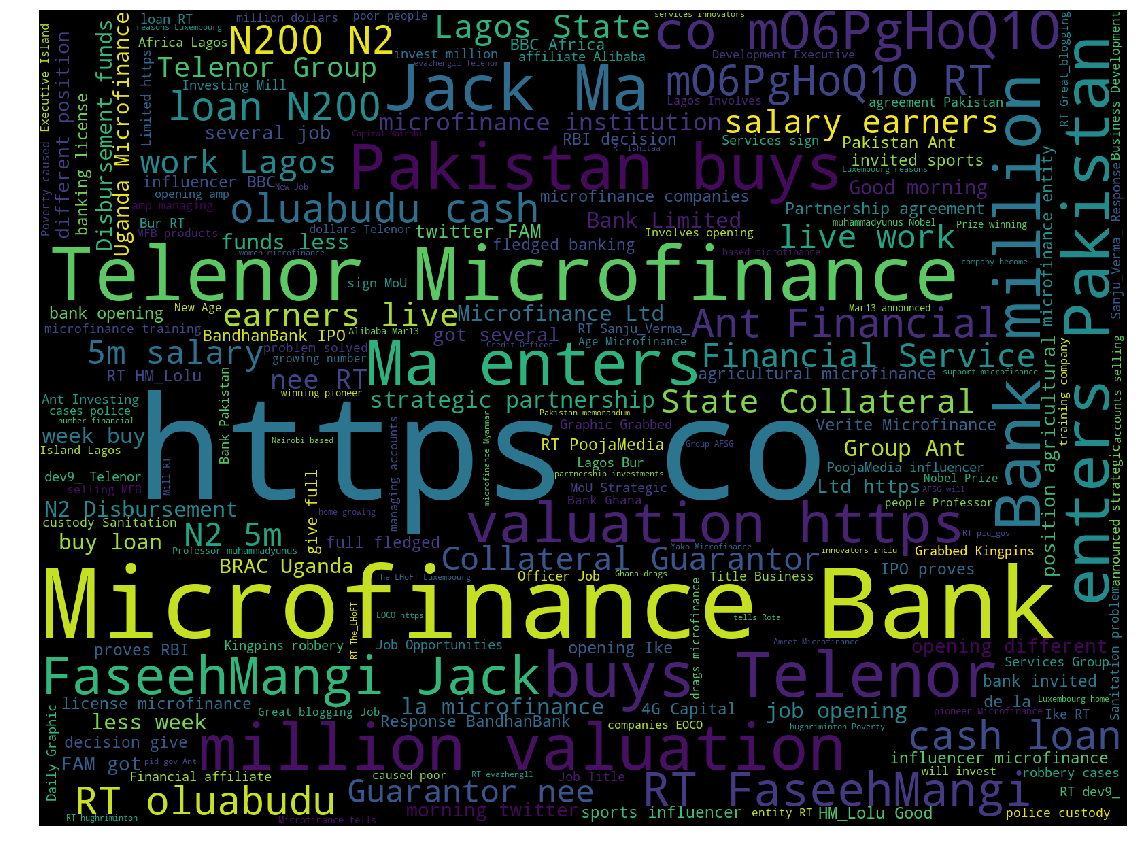

In [15]:
cloud = WordCloud(width=1600, height=1200).generate(" ".join(data['Comments'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

We still appear to have some urls, and Telenor seems to be a big deal.

# Introduction to Naive Bayes
We will begin by running Naive Bayes on the text and check how well it does in predicting classifications. This step is very easy given we have already prepared out data in a bag of words format. <br>

In [16]:
#train your data set using multinomial NB from sklearn library
nb = MultinomialNB()
nb.fit(train_features, train['Sentiment'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
#test your data set on your test data
preds = nb.predict(test_features)

#print the accuracy of your model
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

'Accuracy : 83.77%'

The accuracy is high at ~84%. Most sentiment analysis algorithms have an accuarcy of ~80% when you have fitted the model on proper training data. In this case, the 84% accuracy is likely inflated because we've used TextBlob to determine the correct sentiment in our training data. 

The current measurement of accuracy is a one-dimensional value. We don't know what we're messing up when we classify the sentiments wrong. One tool to better understand how we're misclassifying is called a confusion matrix (first introduced in module X: Logistic Regression.)

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 47   8   7]
 [ 36 307  29]
 [  4  21 188]]
Normalized confusion matrix
[[0.75806452 0.12903226 0.11290323]
 [0.09677419 0.82526882 0.07795699]
 [0.01877934 0.09859155 0.88262911]]


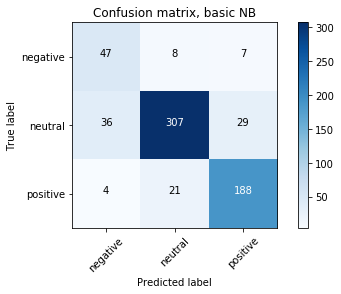

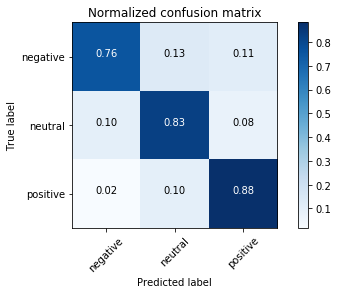

In [19]:
class_names = set(data['Sentiment'])
cnf_matrix = confusion_matrix(test['Sentiment'], preds)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, basic NB')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

The above results show that we're commonly predicting positive comments as netural. This misclassification is not as concerning as our second common misclassification of negative comments as positive.

# Improvement 1: Dealing with Negation

To improve on simple Naive Bayes for sentiment analysis, we can adjust our tokenizer for negation in sentences. (See module 10 lecture slides for full details.) Mark negation is a library we can use in NLTK that appends a "_NEG" to words after a negation until a punctuation mark. This means that the words after a negation will be handled differently than the words before a negation. We can investgate whether using negation will improve our model. Given wordnet did not classify negation properly, this method will unfortunately probably not improve the model.

In [20]:
# Example of mark_negation
print(mark_negation("I like BBQ chicken pizza . I like pepperoni pizza.".split()))
print(mark_negation("I don't like BBQ chicken pizza . I like pepperoni pizza only .".split()))

# Test using mark_negation with text_process
text = "I don't like BBQ chicken pizza. I like pepperoni pizza only."
print(mark_negation(text_process(text)))

['I', 'like', 'BBQ', 'chicken', 'pizza', '.', 'I', 'like', 'pepperoni', 'pizza.']
['I', "don't", 'like_NEG', 'BBQ_NEG', 'chicken_NEG', 'pizza_NEG', '.', 'I', 'like', 'pepperoni', 'pizza', 'only', '.']
['dont', 'like_NEG', 'BBQ_NEG', 'chicken_NEG', 'pizza_NEG', 'like_NEG', 'pepperoni_NEG', 'pizza_NEG']


In [21]:
# To incorporate it into our Naive Bayes model, we will need to adjust how we process our data in creating a bag of words
vectorizer_negation = CountVectorizer(analyzer='word', tokenizer = lambda text: mark_negation(text_process(text)))
train_features_negation = vectorizer_negation.fit_transform(train['Comments'])
test_features_negation = vectorizer_negation.transform(test['Comments'])

In [22]:
#train your data set using multinomial NB from sklearn library
nb = MultinomialNB()
nb.fit(train_features_negation, train['Sentiment'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
#test your data set on your test data
preds = nb.predict(test_features_negation)

#print the accuracy of your model
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

'Accuracy : 84.70%'

As predicted, using negation has not improved our accuracy.

# Improvement 2: Bigrams
What if we tried using bigrams instead? How would using bigrams change the accuracy of our model? Usually including bigrams is a good model booster for any kind of Naive Bayes model, not just sentiment analysis. CountVectorizer makes it easy for us to input bigrams into our Naive Bayes model with a ngram_range parameter. The first value in the tuple specifies the lowest ngram we will track, and the second, the highest. In this case, we will consider both unigrams and bigrams. <br>

In [24]:
#Use bigrams with countvectorizer
vectorizer_bigrams = CountVectorizer(analyzer="word", ngram_range = (1,2), encoding='ISO-8859-1', lowercase=False)
train_features_bigrams = vectorizer_bigrams.fit_transform(train['Comments'])
test_features_bigrams  = vectorizer_bigrams.transform(test['Comments'])

In [25]:
#test the bigrams function worked as expected
vectorizer_bigrams.vocabulary_

{'RT': 6049,
 'ecosmob': 11914,
 'Ecosmob': 2454,
 'Mobility': 5026,
 'solutions': 17597,
 'for': 12579,
 'Banking': 1393,
 'Microfinance': 4794,
 'and': 8438,
 'other': 16030,
 'financial': 12455,
 'institutions': 13834,
 'help': 13237,
 'in': 13500,
 'improving': 13497,
 'customer': 11371,
 'experien': 12244,
 'RT ecosmob': 6260,
 'ecosmob Ecosmob': 11915,
 'Ecosmob Mobility': 2455,
 'Mobility solutions': 5027,
 'solutions for': 17599,
 'for Banking': 12588,
 'Banking Microfinance': 1397,
 'Microfinance and': 4898,
 'and other': 8569,
 'other financial': 16031,
 'financial institutions': 12463,
 'institutions help': 13846,
 'help in': 13242,
 'in improving': 13624,
 'improving customer': 13498,
 'customer experien': 11372,
 'Project': 5896,
 'have': 13168,
 'big': 9239,
 'future': 12842,
 'is': 13988,
 'believed': 9184,
 'by': 9452,
 'many': 14832,
 'to': 18521,
 'be': 9103,
 'the': 18105,
 'potential': 16457,
 'key': 14287,
 'helping': 13261,
 'fight': 12407,
 'even': 12189,
 'most'

In [26]:
#train your data set using multinomial NB from sklearn library
nb = MultinomialNB()
nb.fit(train_features_bigrams, train['Sentiment'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
#test your data set on your test data
preds = nb.predict(test_features_bigrams)

#print the accuracy of your model
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

'Accuracy : 87.64%'

As expected, adding bigrams slightly improves the accuracy of our Naive Bayes model.<br>

# Improvement 3: Binary count Naive Bayes

Another improvement specific to sentiment analysis is binary count. Using binary count Naive Bayes isn't guaranteed to improve your model, but it frequently does when sentiment analysis is involved. To incorporate this to our model, we will update the text_process function to remove duplicates.

In [28]:
#update the text_process function to get rid of duplicates in the reviews

def text_process_binary(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned lemmatized text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    nostopwords = [lemmatizer.lemmatize(word) for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return list(set(nostopwords))

In [29]:
#Use bigrams with countvectorizer
vectorizer_binary = CountVectorizer(analyzer=text_process_binary)
train_features_binary = vectorizer_binary.fit_transform(train['Comments'])
test_features_binary =  vectorizer_binary.transform(test['Comments'])

In [30]:
#train your data set using multinomial NB from sklearn library
nb = MultinomialNB()
nb.fit(train_features_binary, train['Sentiment'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
#test your data set on your test data
preds = nb.predict(test_features_binary)

#print the accuracy of your model
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

'Accuracy : 84.39%'

Unfortunately, adding binary count does not improve the accuracy of our Naive Bayes model in this sample of data.<br>

# Improvement 4: Dealing with informal text
Lastly, another improvement specific to sentiment analysis is to deal more specifically with informal test. Common informal text related to sentiment analysis are emojis and informal text, like all caps, to represent excitement. To deal with emojis, we will update our text_process function, and to deal with capitalization, we will turn off the lowercase parameter in the CountVectorizer initializer. Given wordnet did not consider capitalization and emojis when classifying the data in the first place, this method will unfortunately probably not change the accuracy of the model.

In [32]:
#all capitalized phrases are taken into account as a different word, but accounting for simple emojis is helpful

def text_process_informal(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of lemmatized words
    '''
    nopunc = [text[i] for i in range(len(text)) if (text[i] not in string.punctuation) or \
              (text[i:i+2] in [":(", ":)"]) or (text[i]+text[i-1] in [":(", ":)"]) or \
              (text[i:i+2] in ["(:", "):"]) or (text[i]+text[i-1] in ["(:", "):"])]
    nopunc = ''.join(nopunc)
    
    nostopwords = [lemmatizer.lemmatize(word) for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return nostopwords

In [33]:
#test on a sample text  to make sure the update worked
text = ":I LOVE love BBQ chicken pizza. I eat it every day, but sometimes I wonder if I'm being unhealthy :) :("
text_process_informal(text)

[':I',
 'LOVE',
 'love',
 'BBQ',
 'chicken',
 'pizza',
 'eat',
 'every',
 'day',
 'sometimes',
 'wonder',
 'Im',
 'unhealthy',
 ':)',
 ':(']

In [34]:
#Use bigrams with countvectorizer
vectorizer_informal = CountVectorizer(analyzer=text_process_informal, lowercase = False)
train_features_informal = vectorizer_informal.fit_transform(train['Comments'])
test_features_informal =  vectorizer_informal.transform(test['Comments'])

In [35]:
#train your data set using multinomial NB from sklearn library
nb = MultinomialNB()
nb.fit(train_features_informal, train['Sentiment'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
#test your data set on your test data
preds = nb.predict(test_features_informal)

#print the accuracy of your model
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

'Accuracy : 84.85%'

As predicted, the accuracy did not change much from basic Naive Bayes.

# Conclusion

We've reviewed the basics of Naive Bayes and investigated how improvements can be used in the case of sentiment analysis. Our results are a bit skewed due to the methodology of original classification, but it seems that using bigrams (or any form of ngrams) was the most effective way to improve the model. 

We hope that this module has taught you that real life data is messy, and that building a model is more an art than a science. There are many kinds of small improvements you can make to a Naive Bayes model, and it often depends on the nature of your data. For instance, if you know the text you're using will be particularly informal, it may be good to adapt your analyzer function to account for those informalities. If the text is not informal, this adjustment will not change much to your model accuracy.

Sources: https://medium.com/tensorist/classifying-yelp-reviews-using-nltk-and-scikit-learn-c58e71e962d9, https://www.dataquest.io/blog/naive-bayes-tutorial/, http://nlpforhackers.io/sentiment-analysis-intro/, http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html <br>